In [ ]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
torch.cuda.device_count()

In [ ]:
import transformers    

model = transformers.AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b",
    use_auth_token=True,
    device_map="auto",
    offload_folder="./offload",
    attn_implementation="eager"
)

tokenizer = transformers.AutoTokenizer.from_pretrained("google/gemma-2-2b")
if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})

from models.gemma_2 import Gemma

hooked_model = Gemma(model, tokenizer)


In [ ]:
import json
with open("cache/accuracies_sorted_gemma.json", "r") as file:
    accuracies_sorted = json.load(file)

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torch
import tasks.truthfulqa
task = tasks.truthfulqa.TruthfulQA("probing")
tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=2, subset=False, random_seed=42, subset_len=100, max_length=1000)


steering_directions = {layer: None for layer in range(26)}
stds = {layer: None for layer in range(26)}

all_activations = {pos : [] for pos in steering_directions.keys()}

dataloader = DataLoader(tokenized_dataset, batch_size=2, shuffle=False)

with torch.no_grad():
    for batch in tqdm(dataloader):
        batch_tokens = batch["tokens"].cuda()
        hooked_model.model(batch_tokens)

        for layer in steering_directions.keys():
            all_activations[layer].append(torch.hstack([
                hooked_model.cache_activations[(layer, head)][
                np.arange(batch_tokens.shape[0]), batch["len_of_input"] - 1, :].detach().cpu() for head in range(8)]))

for layer in steering_directions.keys():
    all_activations_dataset = torch.vstack(all_activations[layer])
    X = all_activations_dataset.numpy()
    y = np.array([1 if item["label"] == "True" else -1 for item in tokenized_dataset])
    pos_activations = X[y == 1]
    neg_activations = X[y == -1]
    steering_directions[layer] = np.mean(pos_activations, axis=0) - np.mean(neg_activations, axis=0)
    direction_norm = np.linalg.norm(steering_directions[layer])
    stds[layer] = np.std(np.dot(X, steering_directions[layer]) / direction_norm)

In [ ]:
import json
# with open("cache/steering_directions_gemma_full_layer.json", "w") as file:
#     json.dump({str(item): steering_directions[item].tolist() for item in steering_directions}, file)
# with open("cache/stds_gemma_full_layer.json", "w") as file:
#     json.dump({str(item): stds[item].item() for item in stds}, file)

import numpy as np
import json
with open("cache/steering_directions_gemma_full_layer.json", "r") as file:
    steering_directions_json = json.load(file)
steering_directions = {}
for item in steering_directions_json:
    steering_directions[eval(item)] = np.array(steering_directions_json[item])
with open("cache/stds_gemma_full_layer.json", "r") as file:
    stds_json = json.load(file)
stds = {}
for item in stds_json:
    stds[eval(item)] = stds_json[item]

In [ ]:
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
import torch
import tasks.truthfulqa
from collections import defaultdict

ks = [1, 2, 3, 4]
alphas = [1, 5, 10, 15]

task = tasks.truthfulqa.TruthfulQA("testing")
tokenized_datasets = []
for seed in [42, 0, 5, 10, 15]:
    tokenized_dataset = task.get_tokenized_dataset(tokenizer=tokenizer, batch_size=16, subset=True, testing_split=False,
                                                random_seed=seed, subset_len=81, max_length=1000)
    tokenized_datasets.append(tokenized_dataset)

accuracies_by_layer = {layer: np.mean([p[0] for p in accuracies_sorted if p[1] == layer]) for layer in range(26)}
accuracies_by_layer_sorted = sorted([[acc, l] for l, acc in accuracies_by_layer.items()])

accs_by_k_alpha = defaultdict(list)
logit_diffs_by_k_alpha = defaultdict(list)
for k in ks:
    for alpha in alphas:
        for dataset_i in range(len(tokenized_datasets)):
            dataloader = DataLoader(tokenized_datasets[dataset_i], batch_size=16, shuffle=False)
            correct = 0
            sum_logit_diff = 0
            positions_to_steer = [(t[1], h, -1) for t in accuracies_by_layer_sorted[:k] for h in range(8)]
            vectors = [alpha * steering_directions[pos[0]][pos[1] * 256:(pos[1] + 1) * 256] * stds[pos[0]] for pos in positions_to_steer]
            hooked_model.set_steering_vectors(vectors, positions_to_steer)
            with torch.no_grad():
                for iter, batch in tqdm(enumerate(dataloader)):
                    batch_tokens = batch["tokens"].cuda()
                    
                    logits = hooked_model.model(batch_tokens).logits
                    correct_logits = [tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in batch["correct_label"]]
                    incorrect_logits = [
                            [
                                tokenizer.convert_tokens_to_ids(chr(ord("A") + label)) for label in range(num_labels) if label != correct_label
                            ]
                            for correct_label, num_labels in zip(batch["correct_label"], batch["num_labels"])
                        ]
                    incorrect_logits_probs = [torch.tensor([logits[batch_i, -1, incorrect_id] for incorrect_id in incorrect_logits[batch_i]]) for batch_i in range(len(incorrect_logits))]
                    max_incorrect_logit = [incorrect_logits[batch_i][torch.argmax(incorrect_logits_probs[batch_i])] for batch_i in range(len(incorrect_logits))]
                    logit_diff = [logits[batch_i, -1, correct_logits[batch_i]] - logits[batch_i, -1, max_incorrect_logit[batch_i]] for batch_i in range(len(incorrect_logits))]
                
                    correct += (torch.tensor(logit_diff) > 0).sum()
                    sum_logit_diff += (torch.tensor(logit_diff)).sum()
            accs_by_k_alpha[(k, alpha)].append(correct / len(tokenized_dataset))
            logit_diffs_by_k_alpha[(k, alpha)].append(sum_logit_diff / len(tokenized_dataset))
            print(k, alpha, dataset_i, accs_by_k_alpha[(k, alpha)])

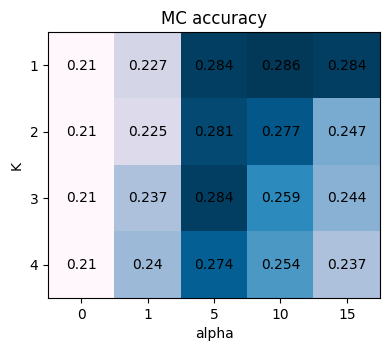

In [1]:
import numpy as np
import json
with open("cache/accs_by_k_alpha_gemma_full_layer_on_probing_dataset.json", "r") as file:
    accs_by_k_alpha_json = json.load(file)
accs_by_k_alpha = {}
for k, v in accs_by_k_alpha_json.items():
    accs_by_k_alpha[eval(k.replace("tensor", ""))] = eval(v.replace("tensor", ""))

ks = sorted(list(set([k for k, a in accs_by_k_alpha.keys()])))

with open("cache/accs_by_k_alpha_gemma_full_layer_on_probing_dataset_no_intervention.json", "r") as file:
    accs_no_intervention_json = json.load(file)
for k in ks:
    accs_by_k_alpha[(k, 0)] = eval(accs_no_intervention_json.replace("tensor", ""))

ks = sorted(list(set([k for k, a in accs_by_k_alpha.keys()])))
alphas = sorted(list(set([a for k, a in accs_by_k_alpha.keys()])))

a = np.zeros((len(ks), len(alphas)))
for k_i, k in enumerate(ks):
    for a_i, alpha in enumerate(alphas):
        a[k_i, a_i] = f"{np.mean(accs_by_k_alpha[(k, alpha)]).item():.3f}"


import matplotlib.pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches((4, 4))
im = ax.imshow(a, cmap="PuBu")

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(alphas)), labels=alphas)
ax.set_yticks(np.arange(len(ks)), labels=ks)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(ks)):
    for j in range(len(alphas)):
        text = ax.text(j, i, a[i, j],
                       ha="center", va="center", color="black")

ax.set_title("MC accuracy")
ax.set_xlabel("alpha")
ax.set_ylabel("K")
fig.tight_layout()
# plt.show()
plt.savefig("images/MC_acc_steering_gemma_full_layer.png")

In [ ]:
test: 1 10 0.27941176470588236 -2.0634484840374365